In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
import random

In [4]:
from gensim.models import KeyedVectors

In [111]:
w2vec_model = KeyedVectors.load_word2vec_format('/home/rony/Downloads/GoogleNews-vectors-negative300.bin', binary=True)

In [112]:
w2vec_model.vectors.shape

(3000000, 300)

In [5]:
all_data = pd.read_csv('all_sentences.csv', encoding='utf-8', index_col=False)
crowd_sourced = pd.read_csv('crowdsourced.csv', encoding='utf-8', index_col=False)
groundtruth = pd.read_csv('groundtruth.csv', encoding='utf-8', index_col=False)

In [106]:
all_data.columns

Index(['Sentence_id', 'Text', 'Speaker', 'Speaker_title', 'Speaker_party',
       'Speaker_role', 'File_id', 'Length', 'Line_number', 'Sentiment'],
      dtype='object')

In [107]:
crowd_sourced.columns

Index(['Sentence_id', 'Text', 'Speaker', 'Speaker_title', 'Speaker_party',
       'File_id', 'Length', 'Line_number', 'Sentiment', 'Verdict'],
      dtype='object')

In [108]:
groundtruth.columns

Index(['Sentence_id', 'Text', 'Speaker', 'Speaker_title', 'Speaker_party',
       'File_id', 'Length', 'Line_number', 'Sentiment', 'Verdict'],
      dtype='object')

In [6]:
len(all_data), len(crowd_sourced), len(groundtruth)

(32072, 22501, 1032)

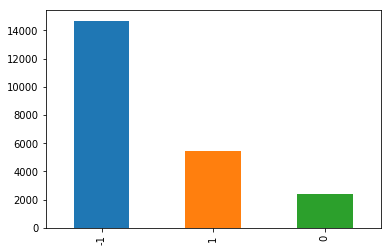

In [7]:
crowd_sourced.Verdict.value_counts().plot.bar()

In [8]:
crowd_sourced.Verdict.value_counts()

-1    14685
 1     5413
 0     2403
Name: Verdict, dtype: int64

In [9]:
groundtruth.head(2)

,Sentence_id,Text,Speaker,Speaker_title,Speaker_party,File_id,Length,Line_number,Sentiment,Verdict
0,26,"You know, I saw a movie - ""Crocodile Dundee.""",George Bush,Vice President,REPUBLICAN,1988-09-25.txt,9,26,0.000000,0
1,80,We're consuming 50 percent of the world's coca...,Michael Dukakis,Governor,DEMOCRAT,1988-09-25.txt,8,80,-0.740979,1


In [109]:
groundtruth = groundtruth.sample(frac=1).reset_index(drop=True)

In [110]:
groundtruth.head(5)

,Sentence_id,Text,Speaker,Speaker_title,Speaker_party,File_id,Length,Line_number,Sentiment,Verdict
0,15638,"So that pledge isn't realistic, and I think th...",Michael Dukakis,Governor,DEMOCRAT,1988-10-13.txt,22,170,0.000000,-1
1,12568,And you cannot fight a victory for Communism o...,Richard M. Nixon,Vice President,REPUBLICAN,1960-10-21.txt,23,76,0.000000,-1
2,10464,It's our job to fix the problem.,John McCain,Senator,REPUBLICAN,2008-10-07.txt,7,63,-0.433056,-1
3,7540,I'm asking for your vote.,George W. Bush,President,REPUBLICAN,2004-10-13.txt,5,1126,0.000000,-1
4,13144,Then I believe that we should move full time o...,John F. Kennedy,Senator,DEMOCRAT,1960-10-13.txt,19,93,0.000000,-1


In [7]:
data = pd.concat([crowd_sourced, groundtruth])

In [8]:
data.shape

(23533, 10)

In [9]:
data = data.sample(frac=1).reset_index(drop=True)

In [10]:
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

In [11]:
input_sentences = [text_to_wordlist(text).split() for text in data["Text"].values.tolist()]
labels = data["Verdict"].values.tolist()

In [12]:
len(input_sentences)

23533

In [13]:
input_sentences[0]

['yes', 'i', 'voted', 'for', 'it', 'supported', 'it']

In [132]:
random.randint(1,2)

1

In [15]:
# Initialize word2id and label2id dictionaries that will be used to encode words and labels
word2id = dict()
label2id = dict()

max_words = 0 # maximum number of words in a sentence

# Construction of word2id dict
for sentence in input_sentences:
    for word in sentence:
        # Add words to word2id dict if not exist
        if word.lower() not in word2id:
            word2id[word.lower()] = len(word2id)
    # If length of the sentence is greater than max_words, update max_words
    if len(sentence) > max_words:
        max_words = len(sentence)
        
word2id['_unk_'] = len(word2id) + 1
# Construction of label2id and id2label dicts
label2id = {l: i for i, l in enumerate(set(labels))}
id2label = {v: k for k, v in label2id.items()}
id2label

{0: 0, 1: 1, 2: -1}

In [16]:
max_words

163

In [17]:
len(word2id)

11955

In [18]:
word2id['_unk_']

11955

In [19]:
random_index = random.sample(range(0, len(input_sentences)), 1000)
for idx in random_index:
    sent = input_sentences[idx]
    if len(sent) <= 10:
        unk_count = 1
    elif len(sent) > 10 and len(sent) <= 50:
        unk_count = random.randint(1,2)
    else:
        unk_count = random.randint(1,3)
    unk_idx = random.sample(range(0, len(sent)), unk_count)
    for _idx in unk_idx:
        sent[_idx] = '_unk_'

In [20]:
import pickle
with open('fact_vocab.p', 'wb') as fp:
    pickle.dump(word2id, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
import keras

# Encode input words and labels
X = [[word2id[word.lower()] for word in sentence] for sentence in input_sentences]
Y = [label2id[label] for label in labels]

# Apply Padding to X
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, max_words)

# Convert Y to numpy array
Y = keras.utils.to_categorical(Y, num_classes=len(label2id), dtype='float32')

# Print shapes
print("Shape of X: {}".format(X.shape))
print("Shape of Y: {}".format(Y.shape))

Shape of X: (23533, 163)
Shape of Y: (23533, 3)


In [22]:
X_test = X[20000:]
X = X[:20000]
Y_test = Y[20000:]
Y = Y[:20000]
print("Shape of X: {}".format(X.shape))
print("Shape of Y: {}".format(Y.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of Y_test: {}".format(Y_test.shape))

Shape of X: (20000, 163)
Shape of Y: (20000, 3)
Shape of X_test: (3533, 163)
Shape of Y_test: (3533, 3)


In [23]:
embedding_dim = 100 # The dimension of word embeddings

# Define input tensor
sequence_input = keras.Input(shape=(max_words,), dtype='int32')

# Word embedding layer
embedded_inputs =keras.layers.Embedding(len(word2id) + 1,
                                        embedding_dim,
                                        input_length=max_words)(sequence_input)

# Apply dropout to prevent overfitting
embedded_inputs = keras.layers.Dropout(0.2)(embedded_inputs)

# Apply Bidirectional LSTM over embedded inputs
lstm_outs = keras.layers.wrappers.Bidirectional(
    keras.layers.LSTM(embedding_dim, return_sequences=True)
)(embedded_inputs)

# Apply dropout to LSTM outputs to prevent overfitting
lstm_outs = keras.layers.Dropout(0.2)(lstm_outs)

# Attention Mechanism - Generate attention vectors
input_dim = int(lstm_outs.shape[2])
permuted_inputs = keras.layers.Permute((2, 1))(lstm_outs)
attention_vector = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm_outs)
attention_vector = keras.layers.Reshape((max_words,))(attention_vector)
attention_vector = keras.layers.Activation('softmax', name='attention_vec')(attention_vector)
attention_output = keras.layers.Dot(axes=1)([lstm_outs, attention_vector])

# Last layer: fully connected with softmax activation
fc = keras.layers.Dense(embedding_dim, activation='relu')(attention_output)
output = keras.layers.Dense(len(label2id), activation='softmax')(fc)

# Finally building model
model = keras.Model(inputs=[sequence_input], outputs=output)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

# Print model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 163)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 163, 100)     1195600     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 163, 100)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 163, 200)     160800      dropout_1[0][0]                  
____________________________________________________________________________________________

In [24]:
# Train model 10 iterations
model.fit(X, Y, epochs=10, batch_size=64, validation_split=0.1, shuffle=True)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 18000 samples, validate on 2000 samples
Epoch 1/10
18000/18000 [==============================] - 69s 4ms/step - loss: 0.7194 - accuracy: 0.7110 - val_loss: 0.5668 - val_accuracy: 0.7675
Epoch 2/10
18000/18000 [==============================] - 69s 4ms/step - loss: 0.5020 - accuracy: 0.8027 - val_loss: 0.5228 - val_accuracy: 0.7860
Epoch 3/10
18000/18000 [==============================] - 63s 3ms/step - loss: 0.4016 - accuracy: 0.8455 - val_loss: 0.5342 - val_accuracy: 0.7905
Epoch 4/10
18000/18000 [==============================] - 62s 3ms/step - loss: 0.3235 - accuracy: 0.8806 - val_loss: 0.6006 - val_accuracy: 0.7750
Epoch 5/10
18000/18000 [==============================] - 57s 3ms/step - loss: 0.2640 - accuracy: 0.9047 - val_loss: 0.6726 - val_accuracy: 0.7775
Epoch 6/10
18000/18000 [==============================] - 62s 3ms/step - loss: 0.2206 - accuracy: 0.9217 - val_loss: 0.7175 - val_accuracy: 0.7630
Epoch 7/10
18000/18000 [==============================] - 59s 3ms/ste

In [25]:
## Saving Model
model.save("fact_checking_model.h5")

In [26]:
##Loading Model
from keras.models import load_model
model = load_model('fact_checking_model.h5')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 163)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 163, 100)     1195600     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 163, 100)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 163, 200)     160800      dropout_1[0][0]                  
____________________________________________________________________________________________

In [27]:
pred = model.predict(X_test)
y_pred = pred.argmax(axis=-1)

In [28]:
Y_test = Y_test.argmax(axis=-1)

In [29]:
target_names=['UFS', 'FS', 'NFS']

In [30]:
from sklearn.metrics import classification_report

In [49]:
from sklearn.metrics import precision_recall_fscore_support

In [57]:
precision_recall_fscore_support(Y_test, y_pred, average='weighted')[0]

0.7499640656119635

In [48]:
print(classification_report(Y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         UFS       0.44      0.32      0.37       368
          FS       0.63      0.65      0.64       816
         NFS       0.84      0.87      0.85      2349

    accuracy                           0.76      3533
   macro avg       0.64      0.61      0.62      3533
weighted avg       0.75      0.76      0.75      3533



In [38]:
##. Cross Validation

In [54]:
from sklearn.model_selection import KFold

In [55]:
num_folds = 5

In [59]:
macro_precision_per_fold = []
macro_recall_per_fold = []
macro_f1_per_fold = []
micro_precision_per_fold = []
micro_recall_per_fold = []
micro_f1_per_fold = []

In [60]:
fold_no = 1
for train, test in kfold.split(X, Y):
    model = buildmodel()
    model.fit(X[train], Y[train], epochs=10, batch_size=64, verbose=0)
    pred = model.predict(X[test])
    y_pred = pred.argmax(axis=-1)
    Y_test = Y[test].argmax(axis=-1)
    scores = precision_recall_fscore_support(Y_test, y_pred, average='macro')
    macro_precision_per_fold.append(scores[0])
    macro_recall_per_fold.append(scores[1])
    macro_f1_per_fold.append(scores[2])
    scores = precision_recall_fscore_support(Y_test, y_pred, average='micro')
    micro_precision_per_fold.append(scores[0])
    micro_recall_per_fold.append(scores[1])
    micro_f1_per_fold.append(scores[2])

In [61]:
sum(macro_precision_per_fold)/len(macro_precision_per_fold)

0.6236142556147392

In [62]:
sum(macro_recall_per_fold)/len(macro_recall_per_fold)

0.6112308030793936

In [63]:
sum(micro_precision_per_fold)/len(micro_precision_per_fold)

0.7480980258263885

In [64]:
sum(micro_recall_per_fold)/len(micro_recall_per_fold)

0.7480980258263885

In [41]:
def buildmodel():
    embedding_dim = 100 # The dimension of word embeddings

    # Define input tensor
    sequence_input = keras.Input(shape=(max_words,), dtype='int32')

    # Word embedding layer
    embedded_inputs =keras.layers.Embedding(len(word2id) + 1,
                                            embedding_dim,
                                            input_length=max_words)(sequence_input)

    # Apply dropout to prevent overfitting
    embedded_inputs = keras.layers.Dropout(0.2)(embedded_inputs)

    # Apply Bidirectional LSTM over embedded inputs
    lstm_outs = keras.layers.wrappers.Bidirectional(
        keras.layers.LSTM(embedding_dim, return_sequences=True)
    )(embedded_inputs)

    # Apply dropout to LSTM outputs to prevent overfitting
    lstm_outs = keras.layers.Dropout(0.2)(lstm_outs)

    # Attention Mechanism - Generate attention vectors
    input_dim = int(lstm_outs.shape[2])
    permuted_inputs = keras.layers.Permute((2, 1))(lstm_outs)
    attention_vector = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm_outs)
    attention_vector = keras.layers.Reshape((max_words,))(attention_vector)
    attention_vector = keras.layers.Activation('softmax', name='attention_vec')(attention_vector)
    attention_output = keras.layers.Dot(axes=1)([lstm_outs, attention_vector])

    # Last layer: fully connected with softmax activation
    fc = keras.layers.Dense(embedding_dim, activation='relu')(attention_output)
    output = keras.layers.Dense(len(label2id), activation='softmax')(fc)

    # Finally building model
    model = keras.Model(inputs=[sequence_input], outputs=output)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

    # Print model summary
    return model

In [42]:
estimator= KerasRegressor(build_fn=buildmodel, epochs=10, batch_size=64, verbose=0)

In [43]:
kfold= RepeatedKFold(n_splits=5, n_repeats=1)

In [45]:
results= cross_val_score(estimator, X, Y, cv=kfold, n_jobs=2) 

In [46]:
results.mean()

-1.142590797819267

In [47]:
results

array([-1.15816937, -1.12107016, -1.14735263, -1.12824547, -1.15811636])

In [28]:
list(Y_test).count(0), list(Y_test).count(1), list(Y_test).count(2)

(280, 661, 1560)

In [29]:
y_pred[0:100]

array([2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 2, 1, 2, 2, 0, 1, 1,
       2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2,
       2, 1, 2, 2, 2, 1, 0, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2,
       2, 0, 0, 2, 1, 1, 1, 2, 2, 2, 2, 0])

In [151]:
# Re-create the model to get attention vectors as well as label prediction
model_with_attentions = keras.Model(inputs=model.input,
                                    outputs=[model.output, 
                                             model.get_layer('attention_vec').output])

In [32]:
'i' in word2id

True

In [101]:
tokenized_sample = text_to_wordlist(sample_text).split()
tokenized_sample

['announcer',
 ':',
 'live',
 'from',
 'the',
 'gaillard',
 'center',
 'in',
 'charleston',
 'south',
 'carolina',
 'this',
 'is',
 'the',
 'cbs',
 'news',
 'democratic',
 'debate']

In [102]:
tmp = []
for word in tokenized_sample:
    if word.lower() in word2id:
        tmp.append(word2id[word.lower()])
    else:
        tmp.append(word2id['_unk_'])
encoded_samples = [tmp]

# Padding
encoded_samples = keras.preprocessing.sequence.pad_sequences(encoded_samples, maxlen=max_words)
encoded_samples

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [153]:
model_with_attentions.predict(encoded_samples)

[array([[7.8109838e-03, 8.6440006e-05, 9.9210256e-01]], dtype=float32),
 array([[0.00105436, 0.00103967, 0.00104715, 0.00106706, 0.0010923 ,
         0.00111766, 0.00113956, 0.00115584, 0.00116562, 0.00116908,
         0.00116715, 0.00116121, 0.00115275, 0.00114323, 0.00113382,
         0.00112544, 0.00111865, 0.00111371, 0.00111066, 0.00110934,
         0.00110945, 0.00111064, 0.00111254, 0.0011148 , 0.0011171 ,
         0.00111922, 0.00112098, 0.00112231, 0.00112317, 0.00112359,
         0.00112363, 0.00112339, 0.00112295, 0.0011224 , 0.00112183,
         0.00112129, 0.00112083, 0.00112048, 0.00112024, 0.00112011,
         0.00112008, 0.00112013, 0.00112023, 0.00112036, 0.0011205 ,
         0.00112063, 0.00112075, 0.00112085, 0.00112091, 0.00112095,
         0.00112097, 0.00112096, 0.00112094, 0.00112091, 0.00112088,
         0.00112084, 0.00112082, 0.00112079, 0.00112078, 0.00112077,
         0.00112077, 0.00112077, 0.00112078, 0.00112079, 0.0011208 ,
         0.00112081, 0.00112083

In [154]:
import random
import math

# Select random samples to illustrate
sample_text = 'ANNOUNCER: Live from the Gaillard Center in Charleston, South Carolina, this is the CBS News Democratic debate.'
wrod_lists = sample_text.split()

# Encode samples
tokenized_sample = text_to_wordlist(sample_text).split()
tmp = []
for word in tokenized_sample:
    if word.lower() in word2id:
        tmp.append(word2id[word.lower()])
    else:
        tmp.append(word2id['_unk_'])
encoded_samples = [tmp]

# Padding
encoded_samples = keras.preprocessing.sequence.pad_sequences(encoded_samples, maxlen=max_words)

# Make predictions
label_probs, attentions = model_with_attentions.predict(encoded_samples)

In [155]:
label_probs

array([[7.8109838e-03, 8.6440006e-05, 9.9210256e-01]], dtype=float32)

In [156]:
attentions

array([[0.00105436, 0.00103967, 0.00104715, 0.00106706, 0.0010923 ,
        0.00111766, 0.00113956, 0.00115584, 0.00116562, 0.00116908,
        0.00116715, 0.00116121, 0.00115275, 0.00114323, 0.00113382,
        0.00112544, 0.00111865, 0.00111371, 0.00111066, 0.00110934,
        0.00110945, 0.00111064, 0.00111254, 0.0011148 , 0.0011171 ,
        0.00111922, 0.00112098, 0.00112231, 0.00112317, 0.00112359,
        0.00112363, 0.00112339, 0.00112295, 0.0011224 , 0.00112183,
        0.00112129, 0.00112083, 0.00112048, 0.00112024, 0.00112011,
        0.00112008, 0.00112013, 0.00112023, 0.00112036, 0.0011205 ,
        0.00112063, 0.00112075, 0.00112085, 0.00112091, 0.00112095,
        0.00112097, 0.00112096, 0.00112094, 0.00112091, 0.00112088,
        0.00112084, 0.00112082, 0.00112079, 0.00112078, 0.00112077,
        0.00112077, 0.00112077, 0.00112078, 0.00112079, 0.0011208 ,
        0.00112081, 0.00112083, 0.00112084, 0.00112085, 0.00112085,
        0.00112086, 0.00112087, 0.00112087, 0.00

In [90]:
label_probs = {id2label[_id]: prob for (label, _id), prob in zip(label2id.items(),label_probs[0])}

# Get word attentions using attenion vector
token_attention_dic = {}
max_score = 0.0
min_score = 0.0
for token, attention_score in zip(tokenized_sample, attentions[0][-len(tokenized_sample):]):
    token_attention_dic[token] = math.sqrt(attention_score)

In [91]:
label_probs

{-1: 0.70434064, 0: 0.29564035, 1: 1.909118e-05}

In [92]:
token_attention_dic

{'are': 0.20088818370590472,
 'candidates': 0.4196677925214949,
 'for': 0.337813065287552,
 'here': 0.17001260878105995,
 'nomination': 0.29148494077293763,
 'presidential': 0.2884038044392536,
 'seven': 0.29913532448648184,
 'the': 0.3368980735633713}

In [93]:
def attention2color(attention_score):
    if attention_score > 0.0 and attention_score <= 0.10:
        return "#ffffff"
    elif attention_score > 0.10 and attention_score <= 0.20:
        return "#ffe6e6"
    elif attention_score > 0.20 and attention_score <= 0.30:
        return "#ffcccc"
    elif attention_score > 0.30 and attention_score <= 0.40:
        return "#ffb3b3"
    elif attention_score > 0.40 and attention_score <= 0.50:
        return "#ff9999"
    elif attention_score > 0.50 and attention_score <= 0.60:
        return "#ff8080"
    elif attention_score > 0.60 and attention_score <= 0.70:
        return "#ff6666"
    elif attention_score > 0.70 and attention_score <= 0.80:
        return "#ff4d4d"
    elif attention_score > 0.80 and attention_score <= 0.90:
        return "#ff3333"
    else:
        return "#ff1a1a"

In [94]:
# Build HTML String to viualize attentions
html_text = "<p style='font-size: large'><b>Text:  </b>"
for token, attention in token_attention_dic.items():
    html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention),
                                                                        token)
html_text += "</p>"
# Display text enriched with attention scores 
display(HTML(html_text))


In [50]:
html_text

"<p style='font-size: large'><b>Text:  </b><span style='background-color:#ffffff;'>bernie <span> <span style='background-color:#ffffff;'>and <span> <span style='background-color:#ffffff;'>i <span> <span style='background-color:#ffffff;'>both <span> <span style='background-color:#ffffff;'>want <span> <span style='background-color:#ffe6e6;'>to <span> <span style='background-color:#ffffff;'>see <span> <span style='background-color:#ffffff;'>universal <span> <span style='background-color:#ffffff;'>health <span> <span style='background-color:#ffffff;'>care <span> <span style='background-color:#ffffff;'>but <span> <span style='background-color:#ffffff;'>plan <span> <span style='background-color:#ffffff;'>does <span> <span style='background-color:#ffffff;'>not <span> <span style='background-color:#ffffff;'>explain <span> <span style='background-color:#ffffff;'>how <span> <span style='background-color:#ffffff;'>get <span> <span style='background-color:#ffffff;'>there <span> <span style='backgr

The entire record is such that the unemployment has not been reduced in this country.


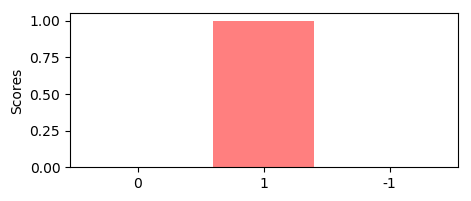

In [77]:
import random
import math

# Select random samples to illustrate
sample_text = random.choice(groundtruth["Text"].values.tolist())
print(sample_text)

# Encode samples
tokenized_sample = text_to_wordlist(sample_text).split()
tmp = []
for word in tokenized_sample:
    if word.lower() in word2id:
        tmp.append(word2id[word.lower()])
    else:
        tmp.append(word2id['_unk'])
encoded_samples = [tmp]
# Padding
encoded_samples = keras.preprocessing.sequence.pad_sequences(encoded_samples, maxlen=max_words)

# Make predictions
label_probs, attentions = model_with_attentions.predict(encoded_samples)
label_probs = {id2label[_id]: prob for (label, _id), prob in zip(label2id.items(),label_probs[0])}

# Get word attentions using attenion vector
token_attention_dic = {}
max_score = 0.0
min_score = 0.0
for token, attention_score in zip(tokenized_sample, attentions[0][-len(tokenized_sample):]):
    token_attention_dic[token] = math.sqrt(attention_score)


# VISUALIZATION
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
    
def attention2color(attention_score):
    if attention_score > 0.0 and attention_score <= 0.10:
        return "#ffffff"
    elif attention_score > 0.10 and attention_score <= 0.20:
        return "#ffe6e6"
    elif attention_score > 0.20 and attention_score <= 0.30:
        return "#ffcccc"
    elif attention_score > 0.30 and attention_score <= 0.40:
        return "#ffb3b3"
    elif attention_score > 0.40 and attention_score <= 0.50:
        return "#ff9999"
    elif attention_score > 0.50 and attention_score <= 0.60:
        return "#ff8080"
    elif attention_score > 0.60 and attention_score <= 0.70:
        return "#ff6666"
    elif attention_score > 0.70 and attention_score <= 0.80:
        return "#ff4d4d"
    elif attention_score > 0.80 and attention_score <= 0.90:
        return "#ff3333"
    else:
        return "#ff1a1a"
#     r = 255 - int(attention_score * 255)
#     color = rgb_to_hex((255, r, r))
#     return str(color)

    
# Build HTML String to viualize attentions
html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
for token, attention in token_attention_dic.items():
    html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention),
                                                                        token)
html_text += "</p>"
# Display text enriched with attention scores 
display(HTML(html_text))

# PLOT EMOTION SCORES
emotions = [label for label, _ in label_probs.items()]
scores = [score for _, score in label_probs.items()]
plt.figure(figsize=(5,2))
plt.bar(np.arange(len(emotions)), scores, align='center', alpha=0.5, color=['black', 'red', 'green', 'blue', 'cyan', "purple"])
plt.xticks(np.arange(len(emotions)), emotions)
plt.ylabel('Scores')
plt.show()

## Experiment with Word Embeddings

In [166]:
from keras.preprocessing.text import Tokenizer
from keras.initializers import Constant

In [167]:
input_sentences = [text_to_wordlist(text).split() for text in crowd_sourced["Text"].values.tolist()]
labels = crowd_sourced["Verdict"].values.tolist()

In [168]:
# Initialize word2id and label2id dictionaries that will be used to encode words and labels
word2id = dict()
label2id = dict()

max_words = 0 # maximum number of words in a sentence

# Construction of word2id dict
for sentence in input_sentences:
    for word in sentence:
        # Add words to word2id dict if not exist
        if word.lower() not in word2id:
            word2id[word.lower()] = len(word2id)
    # If length of the sentence is greater than max_words, update max_words
    if len(sentence) > max_words:
        max_words = len(sentence)
    
# Construction of label2id and id2label dicts
label2id = {l: i for i, l in enumerate(set(labels))}
id2label = {v: k for k, v in label2id.items()}
id2label

{0: 0, 1: 1, 2: -1}

In [169]:
max_words

163

In [170]:
import keras

# Encode input words and labels
X = [[word2id[word.lower()] for word in sentence] for sentence in input_sentences]
Y = [label2id[label] for label in labels]

# Apply Padding to X
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, max_words)

# Convert Y to numpy array
Y = keras.utils.to_categorical(Y, num_classes=len(label2id), dtype='float32')

# Print shapes
print("Shape of X: {}".format(X.shape))
print("Shape of Y: {}".format(Y.shape))

Shape of X: (22501, 163)
Shape of Y: (22501, 3)


In [171]:
X_test = X[20000:]
X = X[:20000]
Y_test = Y[20000:]
Y = Y[:20000]
print("Shape of X: {}".format(X.shape))
print("Shape of Y: {}".format(Y.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of Y_test: {}".format(Y_test.shape))

Shape of X: (20000, 163)
Shape of Y: (20000, 3)
Shape of X_test: (2501, 163)
Shape of Y_test: (2501, 3)


In [175]:
nb_words = min(MAX_NB_WORDS, len(word2id))+1

embedding_matrix = np.zeros((nb_words, 300))
for word, i in word_index.items():
    if word in w2vec_model.vocab:
        embedding_matrix[i] = w2vec_model.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 1155


In [176]:
nb_words

11798

In [177]:
embedding_dim = 300 # The dimension of word embeddings

# Define input tensor
sequence_input = keras.Input(shape=(max_words,), dtype='int32')

# Word embedding layer
embedded_inputs =keras.layers.Embedding(len(word2id) + 1,
                                        embedding_dim,
                                        embeddings_initializer=Constant(embedding_matrix),
                                        input_length=max_words)(sequence_input)

# Apply dropout to prevent overfitting
embedded_inputs = keras.layers.Dropout(0.2)(embedded_inputs)

# Apply Bidirectional LSTM over embedded inputs
lstm_outs = keras.layers.wrappers.Bidirectional(
    keras.layers.LSTM(embedding_dim, return_sequences=True)
)(embedded_inputs)

# Apply dropout to LSTM outputs to prevent overfitting
lstm_outs = keras.layers.Dropout(0.2)(lstm_outs)

# Attention Mechanism - Generate attention vectors
input_dim = int(lstm_outs.shape[2])
permuted_inputs = keras.layers.Permute((2, 1))(lstm_outs)
attention_vector = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm_outs)
attention_vector = keras.layers.Reshape((max_words,))(attention_vector)
attention_vector = keras.layers.Activation('softmax', name='attention_vec')(attention_vector)
attention_output = keras.layers.Dot(axes=1)([lstm_outs, attention_vector])

# Last layer: fully connected with softmax activation
fc = keras.layers.Dense(embedding_dim, activation='relu')(attention_output)
output = keras.layers.Dense(len(label2id), activation='softmax')(fc)

# Finally building model
model = keras.Model(inputs=[sequence_input], outputs=output)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

# Print model summary
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 163)          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 163, 300)     3539400     input_8[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 163, 300)     0           embedding_8[0][0]                
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 163, 600)     1442400     dropout_9[0][0]                  
____________________________________________________________________________________________

In [178]:
model.fit(X, Y, epochs=5, batch_size=64, validation_split=0.1, shuffle=True)

Train on 18000 samples, validate on 2000 samples
Epoch 1/5
18000/18000 [==============================] - 698s 39ms/step - loss: 0.6677 - accuracy: 0.7343 - val_loss: 0.5904 - val_accuracy: 0.7675
Epoch 2/5
18000/18000 [==============================] - 822s 46ms/step - loss: 0.4847 - accuracy: 0.8106 - val_loss: 0.5555 - val_accuracy: 0.7780
Epoch 3/5
18000/18000 [==============================] - 694s 39ms/step - loss: 0.3829 - accuracy: 0.8539 - val_loss: 0.6268 - val_accuracy: 0.7665
Epoch 4/5
18000/18000 [==============================] - 688s 38ms/step - loss: 0.3026 - accuracy: 0.8845 - val_loss: 0.7012 - val_accuracy: 0.7500
Epoch 5/5
18000/18000 [==============================] - 710s 39ms/step - loss: 0.2265 - accuracy: 0.9149 - val_loss: 0.8138 - val_accuracy: 0.7540


In [179]:
pred = model.predict(X_test)
y_pred = pred.argmax(axis=-1)

In [180]:
Y_test = Y_test.argmax(axis=-1)

In [181]:
target_names=['Non-Factual', 'Non-imp Factual', 'Factual']

In [182]:
print(classification_report(Y_test, y_pred, target_names=target_names))

                 precision    recall  f1-score   support

    Non-Factual       0.38      0.32      0.35       280
Non-imp Factual       0.62      0.46      0.53       661
        Factual       0.77      0.87      0.82      1560

    avg / total       0.69      0.70      0.69      2501

